# Get cell centroids from segmentation masks

The image is just a segmentation mask and does not contain any other metadata (as retrievable using aicsimageio)

In [3]:
## Imports for data handling
from tifffile import imread
import numpy as np
from scipy.ndimage import center_of_mass

## Imports for plotting
import matplotlib.pyplot as plt
from scipy.stats import rankdata

In [4]:
img = imread("../../data/Kuett_2022/MainHer2BreastCancerModel/measured_mask_final_segmentation_hwatershed_500.00_90%.tif")
img.dtype, img.shape ## (z, y, x)

(dtype('uint32'), (152, 488, 652))

In [69]:
## Get cell IDs
labels = np.unique(img)
len(labels), labels.min(), labels.max() ## n_cells, min_label, max_label

(108487, 0, 251833)

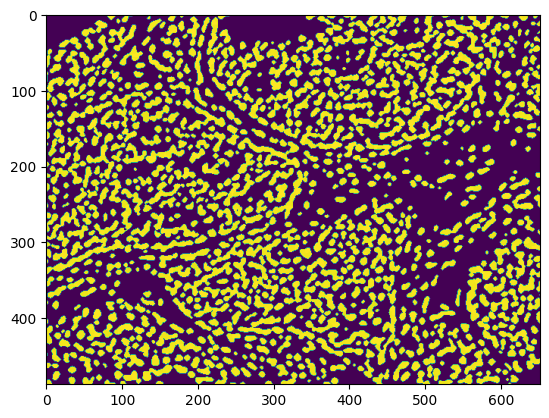

In [70]:
## View first slice
plt.imshow(img[1,:,:])
plt.show()

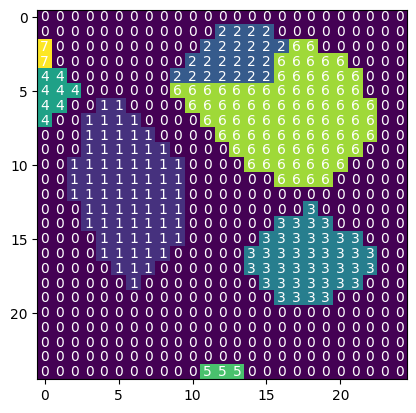

In [71]:
## Create small 2D crop for testing
crop = img[1,103:128,5:30]
crop = rankdata(crop, method='dense').reshape(crop.shape) - 1 ## for plotting

## Plot
fig, ax = plt.subplots()
ax.imshow(crop)
for i in range(crop.shape[0]):
    for j in range(crop.shape[1]):
        text = ax.text(j, i, crop[i, j],
                       ha="center", va="center", color="w")
plt.show()

In [72]:
## Calculate centroids in 2D
labels = np.unique(crop)
labels = labels[labels != 0]

## Compute the centroids
centroids = {}
for label in labels:
    centroids[label] = center_of_mass(crop == label)

## Plot
for centroid in centroids.values():
    plt.scatter(centroid[1], centroid[0], c='red')
plt.imshow(crop)
plt.show()

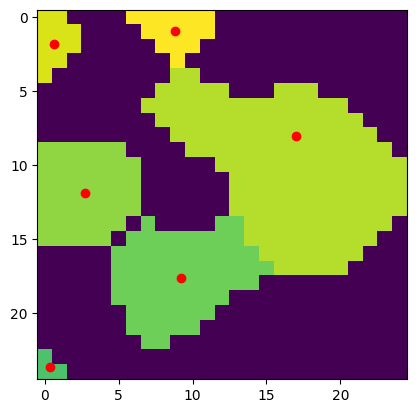

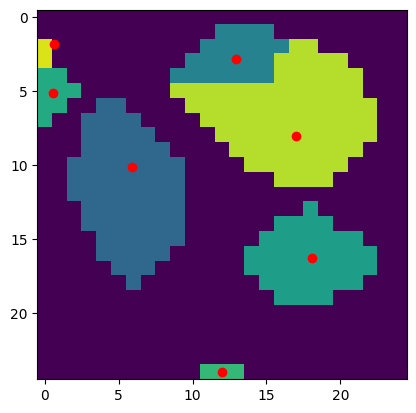

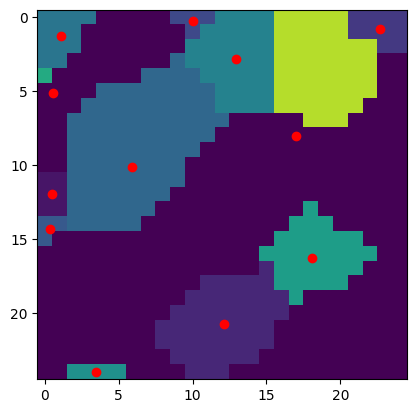

In [73]:
## Calculate centroids on a 3D crop
crop = img[0:3,103:128,5:30]
crop = rankdata(crop, method='dense').reshape(crop.shape) - 1 ## for plotting

labels = np.unique(crop)
labels = labels[labels != 0]

## Compute the centroids
centroids = {}
for label in labels:
    centroids[label] = center_of_mass(crop == label)

for i in np.arange(3): ## skipping duplicated slices
    plt.imshow(crop[i,:,:], vmin=0, vmax=labels.max()) ## one z slice
    curr_labels = np.unique(crop[i,:,:]) ## cells in this z slice
    curr_centroids = [ centroids[label] for label in curr_labels[curr_labels!=0] ]
    for centroid in curr_centroids:
        plt.scatter(centroid[2], centroid[1], c='red')
    plt.show()

In [174]:
## Process the entire image (2D)
## Will create one file per section
outfile_pattern = "../../data/Kuett_2022/MainHer2BreastCancerModel/measured_mask_centroids_2D/measured_mask_centroids_2D_*.csv"
slices_of_interest = img.shape[0] ## all section

# FIXME - this is very slow
for i in range(slices_of_interest):
    outfile = outfile_pattern.replace("*", str(i))
    with(open(outfile, 'w')) as f:
        f.write("z,y,x,id\n")
        img2D = img[i,:,:]
        labels = np.unique(img2D)
        labels = labels[labels != 0]
        for label in labels:
            centroid = center_of_mass(img2D == label)
            f.write(f"{i},{centroid[0]:.2f},{centroid[1]:.2f},{label}\n") ## rounded to 2 decimal places

In [ ]:
## Process the entire image (2D)
## Will create one file per section
from concurrent.futures import ProcessPoolExecutor
outfile_pattern = "../../data/Kuett_2022/MainHer2BreastCancerModel/measured_mask_centroids_2D/measured_mask_centroids_2D_*.csv"
sections = img.shape[0] ## all section

# TODO - test whether this is faster
def get_centroids_2D(img, outfile):
    with(open(outfile, 'w')) as f:
        f.write("z,y,x,id\n")
        labels = np.unique(img)
        labels = labels[labels != 0]
        for label in labels:
            centroid = center_of_mass(img == label)
            f.write(f"{i},{centroid[0]:.2f},{centroid[1]:.2f},{label}\n") ## rounded to 2 decimal places

with ProcessPoolExecutor() as executor: # Parallelize
    for i in range(sections):
        outfile = outfile_pattern.replace("*", str(i))
        executor.submit(get_centroids_2D, img[i,:,:], outfile)

In [7]:
## Process the entire image (3D)
outfile_3D = "../../data/Kuett_2022/MainHer2BreastCancerModel/measured_mask_centroids_3D.csv"
resume = True

# FIXME - this is very slow
labels = np.unique(img)
labels = labels[labels != 0]
if resume: ## get labels that have already been processed
    with(open(outfile_3D, 'r')) as f:
        lines = f.readlines()
    labels_done = [ int(line.split(",")[-1]) for line in lines[1:] ]
    labels = labels[~np.isin(labels, labels_done)]
with open(outfile_3D, ('a' if resume else 'w')) as f:
    if not resume:
        f.write("z,y,x,id\n")
    for label in labels:
        centroid = center_of_mass(img == label)
        f.write(f"{centroid[0]*2:.2f},{centroid[1]:.2f},{centroid[2]:.2f},{label}\n") # accounting for z-axis scaling

In [ ]:
## Get centroids per stack
from joblib import Parallel, delayed
import pickle
import os

sections = np.arange(20,131,10) # Which sections to calculate stack centroids for
outdir = "../../data/temp/measured_mask_centroids/stacks/"
if not os.path.exists(outdir):
    os.makedirs(outdir)
outfile_pattern = "centroids_stack_*.csv"

# Import stacks
fn_stacks = "../../data/temp/Kuett_2022_stacks.pkl"
assert os.path.exists(fn_stacks), "Stack file not found, see scripts/data_processing/minimal_3D_image.ipynb"
with open("../../data/temp/Kuett_2022_stacks.pkl", "rb") as f:
    stacks = pickle.load(f)

# Get and save centroids
for section in sections:
    # Subset img to stack
    crop = img[ stacks[section].min() : stacks[section].max() , : , : ]
    
    # Get unique labels, excluding background (0)
    labels = np.unique(crop)
    labels = labels[labels != 0]

    # Function to compute centroid for a single label
    def compute_centroid(label):
        indices = np.argwhere(crop == label)
        centroid = indices.mean(axis=0)  # (z, y, x)
        centroid[0] *= 2  # z-axis scaling
        return (*centroid, label)

    # Parallel processing
    centroids = Parallel(n_jobs=-1)(delayed(compute_centroid)(label) for label in labels)

    # Convert to NumPy array for easy saving
    centroids_array = np.array(centroids)

    # Save to CSV file
    fn = path.join(outdir, outfile_pattern.replace("*", str(section)))
    np.savetxt(fn, centroids_array, fmt='%.2f,%.2f,%.2f,%d', header='z,y,x,id', delimiter=',')

In [ ]:
import os

os.system("""
    pip freeze > ../../requirements/calculate_centroids.txt
""")